In [1]:
thresh = 1. # voltage spike thresh
dt = 10**-4 # time step
tau = 20 * 10**-3 # membrane time const
N = 1000 # neurons in each pop
K = 100 # number of presynaptic inputs from each pop to each neuron
X_rate = 10 # poisson firing rate of neurons in pop X

# 1. Generating Poisson spike trains 
We simulated the activity of neurons in population X with $N$ Poisson processes. 
We verified our implementation by finding the mean number of spikes per neuron over 2 seconds: $19.943$. This agrees with the prescribed frequency of 10Hz.
Below we also give a raster plot of the spikes from first 10 neurons in the population.

In [2]:
import numpy as np
from numpy.random import rand, binomial
def get_trains(X_rate, dt, N, length):
    return binomial(1, X_rate * dt, size = (N, int(length/dt))) * 1./dt
trains = get_trains(X_rate, dt, N, 2)
print("trains.shape={}".format(trains.shape))
print("mean spikes per neuron in 2s = {}".format(np.mean(np.sum(trains>0,1)))) # This should be approximately 20

trains.shape=(1000, 20000)
mean spikes per neuron in 2s = 19.816


In [3]:
def plot_trains(trains, offset=0, ax = None, color="blue"):
    
    plottable_trains = [(dt*t, i+1+offset) for t in range(trains.shape[1]) for i in range(trains.shape[0]) if trains[i,t]>0]
#     print(plottable_trains)
    if ax:
        ax.set_ylabel("Neuron")
        # plt.xticks(np.arange(0,2,0.1))
        ax.set_xlabel("Time (seconds)")
        if plottable_trains:
            x, y = zip(*plottable_trains)
            ax.scatter(x, y, marker="|", color=color)
        
    else:
        plt.ylabel("Neuron")
        # plt.xticks(np.arange(0,2,0.1))
        plt.xlabel("Time (seconds)")
        if plottable_trains:
            x, y = zip(*plottable_trains)
            plt.scatter(x, y, marker="|", color=color)
    

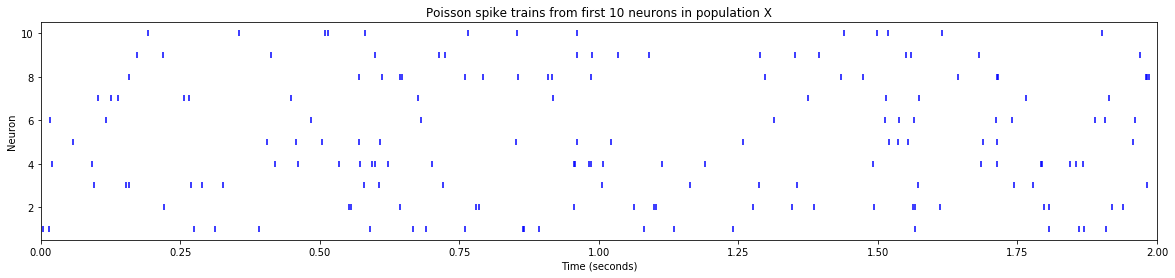

In [4]:
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [20, 4] # changes the default size [w, h]

plot_trains(trains)
plt.xlim(0, 2.)
plt.ylim(0.5, 10.5)
plt.title("Poisson spike trains from first 10 neurons in population X")

# 2. Single LIF neuron with one input spike train

We take one neuron from the previous section and feed its input to a LIF neuron with weight $w=0.9$. 
Below we plot the membrane voltage of the LIF neuron. On the same axes is a raster plot of the spikes from the LIF neuron (blue) and its input (orange).

Notice that every spike of the LIF neuron corresponds to a reset of the membrane voltage to 0 (as we record it after any spike resets) and that every spike of the input neuron corresponds to a jump in the membrane voltage of $0.9$, except when it coincides with a spike of the LIF neuron (where it is reset to 0 before being recorded).

Since $w=0.9$ and $V_{th}=1.0$, the LIF neuron fires whenever an input neuron fires while the membrane voltage is greater than $0.1$.  


In [5]:
def LIF(time, dt, tau, w, thresh, S_in, reset_on_spike = True, plot = True):
    t = [dt * i for i in range(int(time/dt))]
    K = S_in.shape[0]
    n_steps = int(time/dt)
    assert S_in.shape[1] == n_steps
    V = np.zeros(n_steps)
    S_out = np.zeros(n_steps)
    dVdt = np.zeros(n_steps)
    dVdt[0]=-V[0]/tau + w/K * np.sum(S_in[:,0]) if K!=0 else -V[0]/tau
    
    for i in range(1, n_steps): # everything starts at 0
        V[i] = V[i-1] + dt * dVdt[i-1]
        S_out[i] = 1./dt if V[i] > thresh else 0.
        V[i] = 0. if reset_on_spike and S_out[i] else V[i]
        dVdt[i] = -V[i]/tau + w/K * np.sum(S_in[:,i]) if K!=0 else -V[i]/tau
    
    if reset_on_spike:
        return V, S_out
    else:
        return V

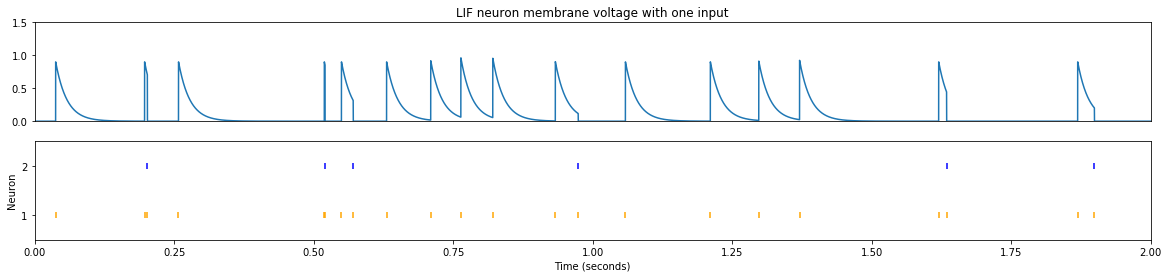

In [18]:
single_train = get_trains(X_rate, dt, 1, 2)
V, S = LIF(2, dt, tau, 0.9, thresh, single_train);

fig,(ax1,ax2) = plt.subplots(2,1)

ax1.plot(np.arange(0,2, 2./20000),V)
ax1.set_xlim(0, 2.)
ax1.set_xticks([])
ax1.set_ylim(0., 1.5)
ax1.set_title("LIF neuron membrane voltage with one input")

plot_trains(np.expand_dims(S,0),offset=1, ax=ax2)

plot_trains(single_train, ax=ax2, color="orange")

ax2.set_xlim(0, 2.)
ax2.set_ylim(0.5, 2.5)
ax2.set_yticks([1, 2])

# 3. Single LIF neuron with many input spike trains


We disabled the reset-on-spike behaviour of the membrane voltage of the LIF and simulated it with with $K=100$ inputs, each with weight $\frac{1}{K}$.
Below is a plot of this non-resetting membrane voltage.


100


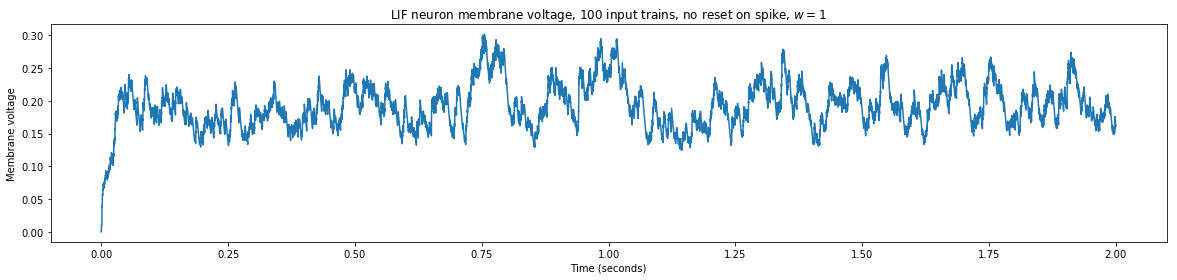

In [19]:
print(K)
V= LIF(2, dt, tau, 1., thresh, get_trains(X_rate, dt, K, 2), reset_on_spike = False)
plt.plot(np.arange(0,2.,dt),V)
plt.title("LIF neuron membrane voltage, 100 input trains, no reset on spike, $w=1$")
plt.ylabel("Membrane voltage")
plt.xlabel("Time (seconds)")

## (b)

We now present a derivation of the theoretical mean and variance of the above membrane voltage.
We will work in discrete time.

We have $h(t) = \frac{w}{K} \sum_{j=1}^{K}S_j(t)$

then $\mu_h=\mathbb{E} h(t) = \frac{w}{K} \sum_{j=1}^{K}\mathbb{E}S_j(t)=wr_X \delta t$, 

and $$\sigma^2_h \delta(s) = \mathbb{E} [h(t)h(t+s)]$$ 

$$= \mathbb{E} \left[\left(\frac{w}{K}\right)^2\sum_{j=1}^{N}\sum_{l=1}^{N}S_j(t)S_l(t+s)\right] $$

$$= \left(\frac{w}{K}\right)^2 \sum_{j=1}^{N}\sum_{l=1}^{N}\mathbb{E} \left[S_j(t)S_l(t+s)\right]$$

$$= \left(\frac{w}{K}\right)^2 \sum_{j=1}^{N}\sum_{l=1}^{N}\mathbb{E} \left[S_j(t)S_l(t+s)\right]$$

$$= \left(\frac{w}{K}\right)^2 \sum_{j=1}^{N}\sum_{l=1}^{N} \mathbb{I}_{[j=l]} \delta(s) \mathbb{E}\left[S_j(t)^2\right]$$

$$= \left(\frac{w}{K}\right)^2 \sum_{j=1}^{N} \delta(s) \frac{r_X}{{\delta t} ^2}$$

$$\sigma^2_h = \frac{w^2}{K} \frac{r_X}{{\delta t}^2}$$


so $\mu = \tau  w r_X \delta t$

and $\sigma^2= \frac{\tau}{2} \frac{w^2}{K} \frac{r_X}{{\delta t}^2}$

Next we plot graphs of these expressions for the mean and variance of the membrane voltage as a function of $K$, as well as several experimental values, each obtained by computing the sample mean and sample variance over time from a 10-second simulation. The values obtained from simulation match the theoretical values closely. 

In [20]:
def mu(K, w, X_rate, tau):
    return tau * w * X_rate * (K > 0.) 

def sigmasq(K, w, X_rate, tau):
    return tau/2. * w**2 * (1./ (K+(K==0))) * X_rate * (K > 0.)


In [21]:
mu_approxes = []
sigma_approxes = []
exp_Ks = [0, 10, 31, 100, 310, 1000]
for exp_K in exp_Ks:
    trains = get_trains(X_rate, dt, exp_K, 10)
    V = LIF(10, dt, tau, 1., thresh, trains, reset_on_spike = False, plot=False)
    mu_approx =  np.mean(V[int(0.1/dt):])
    mu_approxes.append(mu_approx)
    sigma_approx =  np.var(V[int(0.1/dt):] )
    sigma_approxes.append(sigma_approx)

analytic_Ks = np.arange(1001)

In [22]:
print("mu_approxes={}".format(mu_approxes))
print("sigma_approxes={}".format(sigma_approxes))

mu_approxes=[0.0, 0.20420513958633596, 0.20314686850472027, 0.20514027649829519, 0.20192410843619266, 0.20088640112589576]
sigma_approxes=[0.0, 0.010703740347197477, 0.0035946161340322772, 0.00092248669359043306, 0.00032758895441516628, 9.6971302484596483e-05]


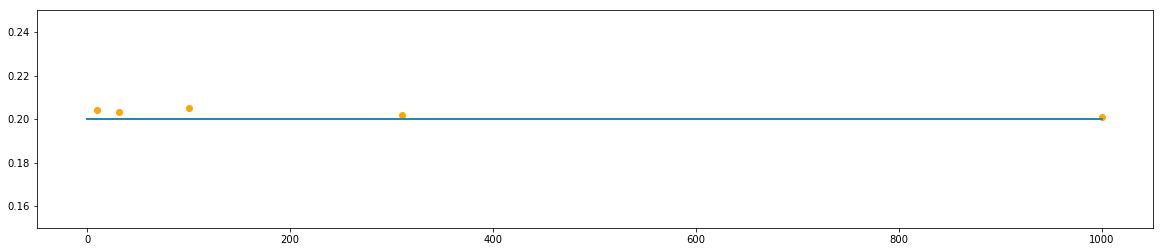

In [23]:
plt.scatter(exp_Ks, mu_approxes, color="orange")
plt.plot(analytic_Ks, [mu(analytic_Ks, 1., X_rate, tau) for _ in analytic_Ks])
plt.ylim(0.15, 0.25);

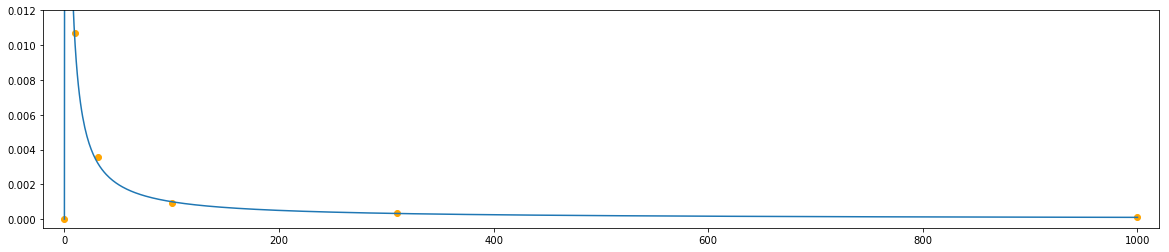

In [24]:
plt.scatter(exp_Ks, sigma_approxes,color="orange")
plt.plot(analytic_Ks, sigmasq(analytic_Ks, 1., X_rate, tau))
plt.ylim(-0.0005, 0.012);
plt.xlim(-20, 1020);

The value of $w$ such that $\mu=V_{th}$ is $w=\frac{V_{th}}{\tau r_X}$. We confirmed this by setting $w$ to this value, $K=100$ and simulating the LIF neuron again. The value we obtained for $\mu$ was $0.9975$, which is very close to $V_{th}=1$. 

In [25]:
trains = get_trains(X_rate, dt, exp_K, 10)
V = LIF(10, dt, tau, thresh/(tau * X_rate), thresh, trains, reset_on_spike = False, plot=False)
mu_approx =  np.mean(V[int(0.1/dt):])
print("mu_approx = {}".format(mu_approx))

mu_approx = 0.9986699917812004


## (e)
We reactivated the reset-on-spike mechanism and found by trial-and-error that setting $w=4.3$ makes the output firing rate approximately 10Hz. 
Using a window of 100ms, we found the Fano factor of the output spike train to be $0.52$. This is not reflective of the amount of spike count variability found in the cortex, which generally has a Fano factor of $>1$. 

(0.5, 12.5)

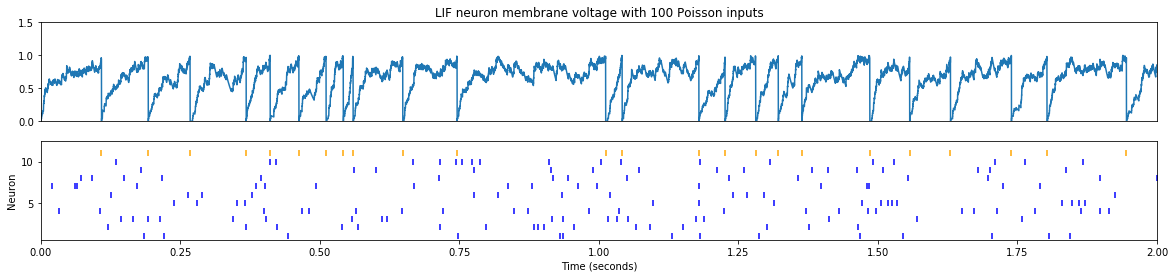

In [37]:
trains = get_trains(X_rate, dt, 100, 10)
V, S = LIF(10, dt, tau, 4.3, thresh, trains, reset_on_spike = True, plot=True)
np.sum(S>0)/10

fig,(ax1,ax2) = plt.subplots(2,1)

ax1.plot(np.arange(0,10, dt),V)
ax1.set_xlim(0, 2.)
ax1.set_xticks([])
ax1.set_ylim(0., 1.5)
ax1.set_title("LIF neuron membrane voltage with 100 Poisson inputs")

plot_trains(np.expand_dims(S,0),offset=10, ax=ax2, color="orange")

plot_trains(trains[:10,:], ax=ax2)

ax2.set_xlim(0, 2.)
ax2.set_ylim(0.5, 12.5)
# ax2.set_yticks(range(1,10))

In [38]:
def get_fano(S):
    window_counts = []
    for start in range(len(S)-int(0.1/dt)):
        n_spikes = np.sum(S[start:start+int(0.1/dt)]>0)
        window_counts.append(n_spikes)
    mean_count = np.mean(window_counts)
    count_var = np.var(window_counts) 
    fano = count_var/mean_count
    return fano
get_fano(S)

0.40080004177186418

# 4 Single LIF neuron with many E and I Poisson inputs

We then considered an LIF neuron with both $K$ excitatory and $K$ inhibitory Poisson inputs. Both types of inputs have rates $r_X$, and weights $\frac{w}{\sqrt{K}}$ and $-\frac{w}{\sqrt{K}}$, respectively. 

The theoretical mean and variance of the membrane voltage for the LIF neuron with the reset-on-spike mechanism removed can be found in a similar way to Exercise 3b. The mean is simply $\mu = 0$ and the variance is $\sigma^2 = 2w^2r_X$. We verified these by simulating the neuron with $K=100$, $w=1.5$. The theoretical and experimental values of $\mu$ were $0$ and $0.0061$ respectively, and for $\sigma^2$ they were $0.45$ and $0.4850$. 

Through trial and error we found that setting $w=1.5$ gave an output spike rate of roughly 10Hz and a Fano factor of $0.9995$. This is much closer to the Fano factors obsered in the cortex.

In [39]:
def LIF_w(length, dt, tau, ws, thresh, S_in, reset_on_spike = True, plot = True):
    t = [dt * i for i in range(int(length/dt))]
    K = S_in.shape[0]
    n_steps = int(length/dt)
    assert S_in.shape[1] == n_steps
    V = np.zeros(n_steps)
    S_out = np.zeros(n_steps)
    dVdt = np.zeros(n_steps)
    dVdt[0]=-V[0]/tau +  np.dot(ws, S_in[:,0]) if K!=0 else -V[0]/tau
    
    for i in range(1, n_steps): # everything starts at 0
        V[i] = V[i-1] + dt * dVdt[i-1]
        S_out[i] = 1./dt if V[i] > thresh else 0.
        V[i] = 0. if reset_on_spike and S_out[i] else V[i]
        dVdt[i] = -V[i]/tau +  np.dot(ws, S_in[:,i]) if K!=0 else -V[i]/tau
    if plot:
        plt.plot(t, S_in[0,:])
        plt.show()
        plt.plot(t, V)
        plt.show()
    if reset_on_spike:
        if plot:
            plt.plot(t, S_out)
            plt.show()
        return V, S_out
    else:
        return V

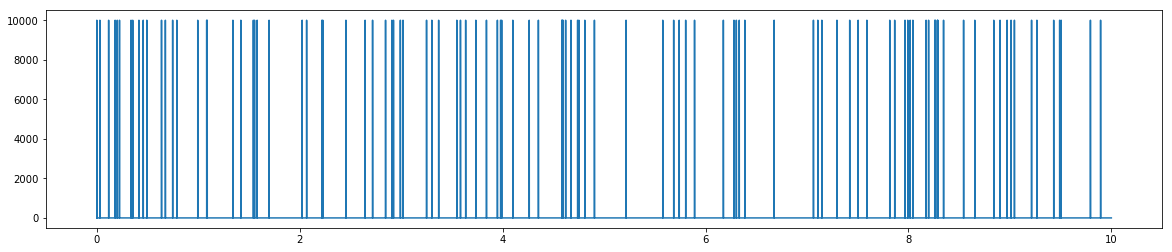

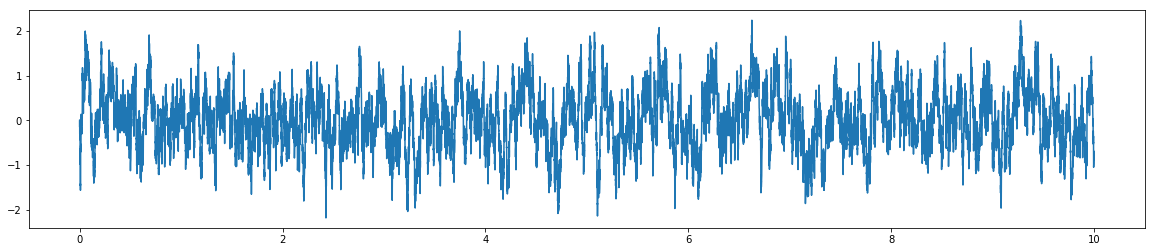

mu_approx=0.005194504792873366
sigma_approx=0.4209800701820498
mu analytic = 0
sigma analytic = 0.44999999999999996


In [40]:
K = 100
w = 1.5
ws = np.concatenate([w/np.sqrt(K) * np.ones(K), -w/np.sqrt(K) * np.ones(K)]) 
trains = get_trains(X_rate, dt, 2*K, 10)
V = LIF_w(length=10, dt=dt, tau=tau, ws=ws, thresh=thresh, S_in = trains, reset_on_spike = False, plot=True)
mu_approx =  np.mean(V[int(0.1/dt):])
sigma_approx =  np.var(V[int(0.1/dt):] )

print("mu_approx={}".format(mu_approx))
print("sigma_approx={}".format(sigma_approx))
print("mu analytic = 0")
print("sigma analytic = {}".format(2*sigmasq(100, w, X_rate, tau)*K))

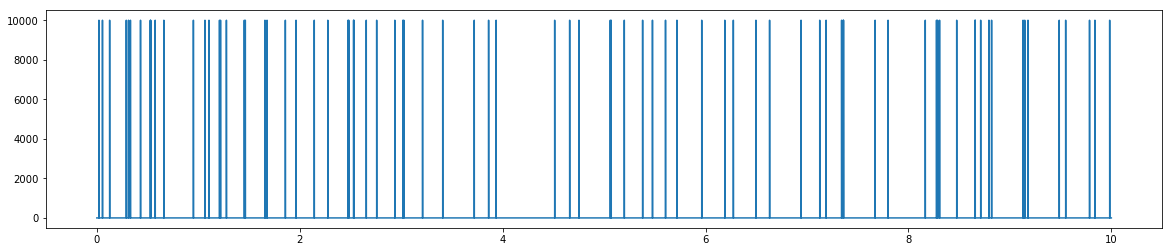

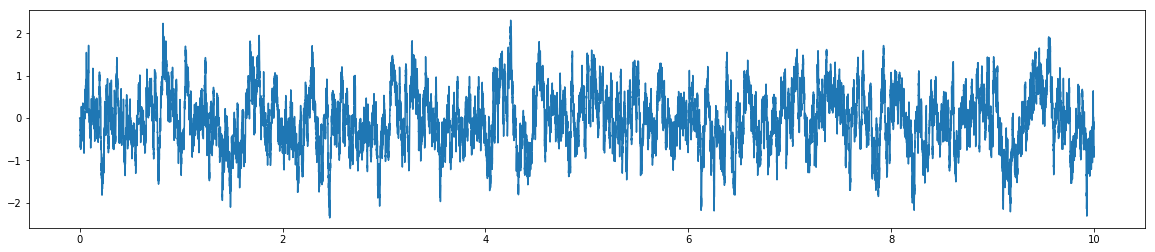

Avg rate = 11.9
Fano factor = 0.4008000417718642


In [41]:

 
trains = get_trains(X_rate, dt, 2*K, 10)
V = LIF_w(length=10, dt=dt, tau=tau, ws=ws, thresh=thresh, S_in = trains, reset_on_spike = False, plot=True)
print("Avg rate = {}".format(np.sum(S>0)/10))
print("Fano factor = {}".format(get_fano(S)))

# 5 Full Network

We then simulated the full network as specified in the handout. 

From the theory given in lectures, we expect the output spike rates $r_E$ and $r_I$ to satisfy:

$$J_{EE}r_E + J_{EI}r_I + J_{EX}r_X = O\left(\frac{1}{\sqrt{K}}\right)\approx 0$$
$$J_{IE}r_E + J_{II}r_I + J_{IX}r_X = O\left(\frac{1}{\sqrt{K}}\right)\approx 0$$

Given the synaptic weight parameters provided we can solve these equations to give: $r_E=r_I=r_X$

The simulations with various values of $r_X$ yielded the following spike rates:

$$
5 6.951 5.78
10 12.9615 11.5755
15 18.275 16.8995
20 23.991 22.2575
$$

It appears that the spike rate of the excitatory neurons is systematically higher than that of the inhibitory neurons. This is not quite in agreement with the prediction made above, but the spike rates are nonetheless similar as predicted.  

We furthermore simulated the network with $N=100$ and $K=100$, that is with full connectivity between all neurons (except that Poisson neurons still have no inputs). Raster plots from each population are shown below. 

Both the excitatory and inhibitory populations exhibit synchronization in their spiking. 
The average firing rates of E and I neurons are 40 and 20Hz, respectively.
Furthermore, it was observed that all spikes happen such that the E neurons fire twice in adjacent timesteps, with the I neurons spiking once during the second spiking of the E neurons. 
This can be explained as follows:

* To begin with, all E and I neurons have 0 membrane voltage. In particular, they are all equal.
* Since we have full connectivity, all E neurons continue to have identical membrane voltages. The same is true of I neurons. 
* Suppose an X neuron fires. The input to excitatory neurons is $\frac{1}{\sqrt{K}}J_{EX} = 0.1$. The input to inhibitory neurons is similarly $0.8$. In general, then, the E neurons will always fire before the I neurons fire.  
* Consider what happens when the E neurons fire. Every E neuron fires at once, so in the following timestep the input to the E neurons will be approximately $\frac{1}{\sqrt{K}}J_{EE}K = 10$, and the input to I neurons will be $8$. 
* So in the following timestep, the E population fires again and the I population fires. However, the input to E neurons from this timestep is $\frac{1}{\sqrt{K}}(J_{EE}+J_{EI}K = -10$ and the input to I neurons is $-8$.
* From the next timestep onwards, the membrane potentials of both the E and I populations slowly return to 0.


In [42]:
def get_Wab(N, K, w):
    W_unshuff = np.concatenate([np.ones([N, K])*w/np.sqrt(K), np.zeros([N, N-K])], 1)
    W = np.zeros([N, N])
    for i in range(N):
        W[i, :] = np.random.permutation(W_unshuff[i,:])
    return W

W=get_Wab(10, 2, 1.0)
W

array([[ 0.        ,  0.70710678,  0.70710678,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.70710678,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.70710678],
       [ 0.        ,  0.70710678,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.70710678],
       [ 0.        ,  0.        ,  0.70710678,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.70710678],
       [ 0.        ,  0.        ,  0.70710678,  0.        ,  0.        ,
         0.        ,  0.        ,  0.70710678,  0.        ,  0.        ],
       [ 0.        ,  0.70710678,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.70710678],
       [ 0.        ,  0.        ,  0.        ,  0.70710678,  0.        ,
         0.70710678,  0.        ,  0.        

In [43]:
np.matmul(np.ones([200,43]), np.ones([43,2340])) # inner dims match

array([[ 43.,  43.,  43., ...,  43.,  43.,  43.],
       [ 43.,  43.,  43., ...,  43.,  43.,  43.],
       [ 43.,  43.,  43., ...,  43.,  43.,  43.],
       ..., 
       [ 43.,  43.,  43., ...,  43.,  43.,  43.],
       [ 43.,  43.,  43., ...,  43.,  43.,  43.],
       [ 43.,  43.,  43., ...,  43.,  43.,  43.]])

In [44]:
W_EE = get_Wab(N=1000, K=100, w=1.) # second index goes to first
W_IE = get_Wab(N=1000, K=100, w=1.) 
W_EI = get_Wab(N=1000, K=100, w=-2.)
W_II = get_Wab(N=1000, K=100, w=-1.8)
W_EX = get_Wab(N=1000, K=100, w=1.)
W_IX = get_Wab(N=1000, K=100, w=0.8)


W_E_all = np.concatenate([W_EE, W_EI, W_EX], 1)
W_I_all = np.concatenate([W_IE, W_II, W_IX], 1)

W = np.concatenate([W_E_all, W_I_all], 0)
W.shape

(2000, 3000)

In [45]:
def full_net(length, dt, tau, thresh, N, K, X_rate, plot = False):
    
    W_EE = get_Wab(N=N, K=K, w=1.) # second index goes to first
    W_IE = get_Wab(N=N, K=K, w=1.) 
    W_EI = get_Wab(N=N, K=K, w=-2.)
    W_II = get_Wab(N=N, K=K, w=-1.8)
    W_EX = get_Wab(N=N, K=K, w=1.)
    W_IX = get_Wab(N=N, K=K, w=0.8)

    W_E_all = np.concatenate([W_EE, W_EI, W_EX], 1)
    W_I_all = np.concatenate([W_IE, W_II, W_IX], 1)

    W = np.concatenate([W_E_all, W_I_all], 0)
    
    trains = get_trains(X_rate, dt, N, length)
    
    t = [dt * i for i in range(int(length/dt))]
    
    n_steps = int(length/dt)
    V = np.zeros([2*N, n_steps])
    S = np.zeros([2*N, n_steps])
    print("V.shape = {}".format(V.shape))
    print("S.shape = {}".format(S.shape))
    
    dVdt = np.zeros([2*N, n_steps])
    dVdt[:,0] = -V[:,0]/tau + np.matmul(W, np.concatenate([S[:,0], trains[:,0]], 0)) 
    
    for i in range(1, n_steps): # everything starts at 0
        V[:, i] = V[:,i-1] + dt * dVdt[:,i-1]
        S[:, i] = 1./dt * (V[:,i] > thresh) 
        V[:, i] = V[:,i] * (1.-(S[:,i]>0.))
        dVdt[:, i] = -V[:,i]/tau + np.matmul(W, np.concatenate([S[:,i], trains[:,i]], 0))
        if i % (n_steps/10) == 0:
            print("at t={}".format(i*dt))
    if plot:
        plt.imshow(trains)
        plt.show()
        plt.imshow(S)
        plt.show()
    return V, S, trains

In [46]:
V, S, trains = full_net(2, dt, tau, thresh, N=1000, K=100, X_rate = X_rate, plot = False)
E_mean = np.mean(np.sum(S[:1000,:]>0, 1),0)/2
I_mean = np.mean(np.sum(S[1000:,:]>0, 1),0)/2
print("E_mean = {}".format(E_mean))
print("I_mean = {}".format(I_mean))

V.shape = (2000, 20000)
S.shape = (2000, 20000)
at t=0.2
at t=0.4
at t=0.6
at t=0.8
at t=1.0
at t=1.2
at t=1.4000000000000001
at t=1.6
at t=1.8
E_mean = 13.1035
I_mean = 11.685


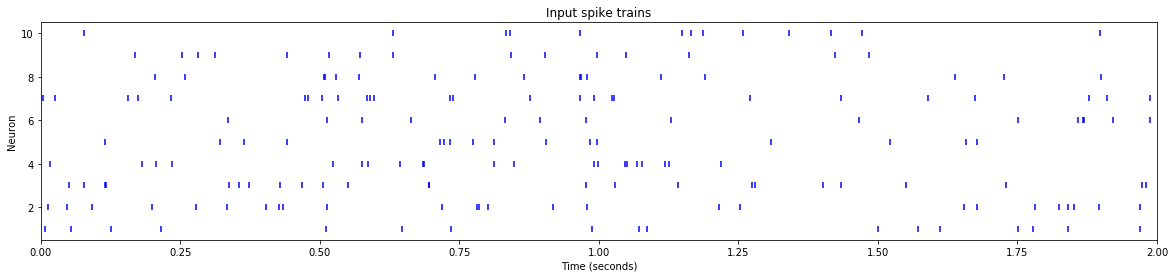

In [47]:
plot_trains(trains)
plt.xlim(0, 2.)
plt.ylim(0.5, 10.5)
plt.title("Input spike trains")

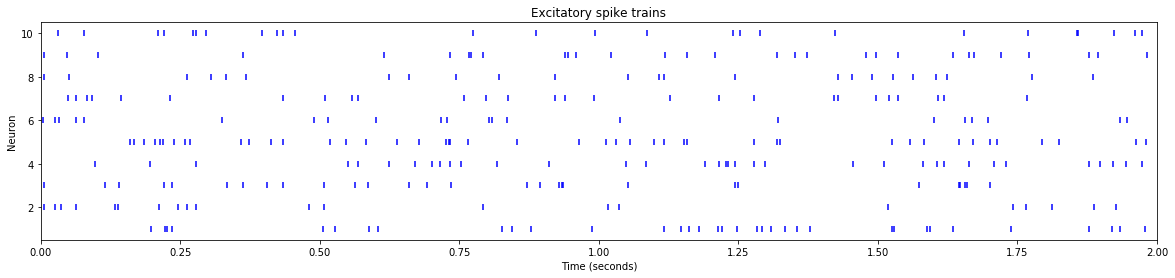

In [48]:
plot_trains(S[:1000,:])
plt.xlim(0, 2.)
plt.ylim(0.5, 10.5)
plt.title("Excitatory spike trains")

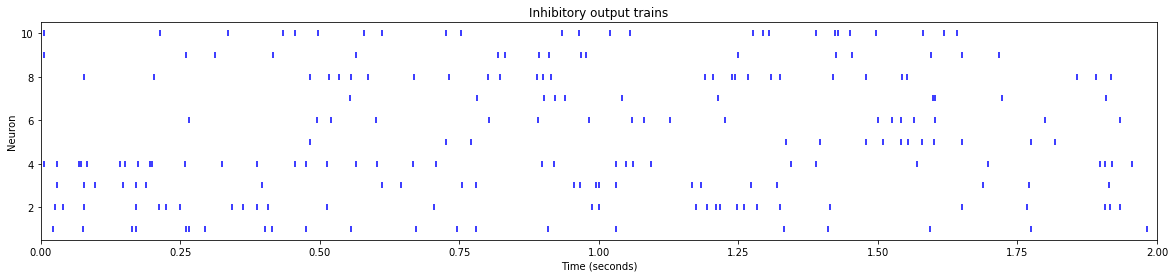

In [49]:
plot_trains(S[1000:,:])
plt.xlim(0, 2.)
plt.ylim(0.5, 10.5)
plt.title("Inhibitory output trains")

In [50]:
X_rates= [5, 10, 15, 20]
E_means=[]
I_means=[]
for X_rate in X_rates:
    V, S, trains = full_net(2, dt, tau, thresh, N=1000, K=100, X_rate = X_rate, plot = False)
    E_means.append(np.mean(np.sum(S[:1000,:]>0, 1),0)/2)
    I_means.append(np.mean(np.sum(S[1000:,:]>0, 1),0)/2)
    
print("X_rates = {}".format(X_rates))
print("E_means = {}".format(E_means))
print("I_means = {}".format(I_means))

V.shape = (2000, 20000)
S.shape = (2000, 20000)
at t=0.2
at t=0.4
at t=0.6
at t=0.8
at t=1.0
at t=1.2
at t=1.4000000000000001
at t=1.6
at t=1.8
V.shape = (2000, 20000)
S.shape = (2000, 20000)
at t=0.2
at t=0.4
at t=0.6
at t=0.8
at t=1.0
at t=1.2
at t=1.4000000000000001
at t=1.6
at t=1.8
V.shape = (2000, 20000)
S.shape = (2000, 20000)
at t=0.2
at t=0.4
at t=0.6
at t=0.8
at t=1.0
at t=1.2
at t=1.4000000000000001
at t=1.6
at t=1.8
V.shape = (2000, 20000)
S.shape = (2000, 20000)
at t=0.2
at t=0.4
at t=0.6
at t=0.8
at t=1.0
at t=1.2
at t=1.4000000000000001
at t=1.6
at t=1.8
X_rates = [5, 10, 15, 20]
E_means = [6.9509999999999996, 12.961499999999999, 18.274999999999999, 23.991]
I_means = [5.7800000000000002, 11.5755, 16.8995, 22.2575]


In [51]:
for xr, em, im in zip(X_rates, E_means, I_means):
    print(xr, em, im)

5 6.951 5.78
10 12.9615 11.5755
15 18.275 16.8995
20 23.991 22.2575


V.shape = (200, 20000)
S.shape = (200, 20000)
at t=0.2
at t=0.4
at t=0.6
at t=0.8
at t=1.0
at t=1.2
at t=1.4000000000000001
at t=1.6
at t=1.8


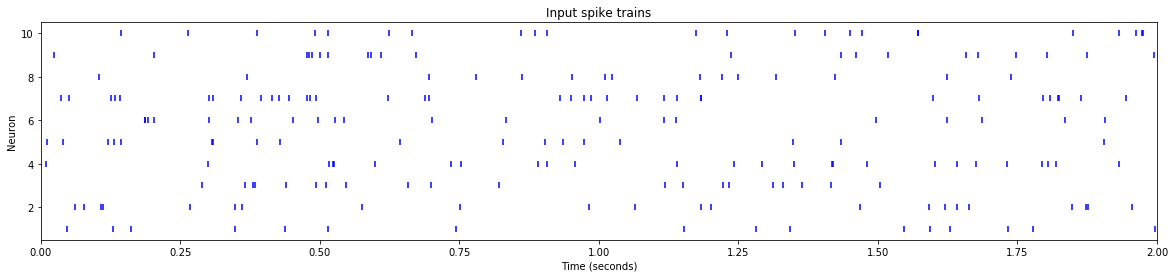

In [66]:
V, S, trains = full_net(2, dt, tau, thresh, N=100, K=100, X_rate = 10, plot = False)

plot_trains(trains)
plt.xlim(0, 2.)
plt.ylim(0.5, 10.5)
plt.title("Input spike trains")

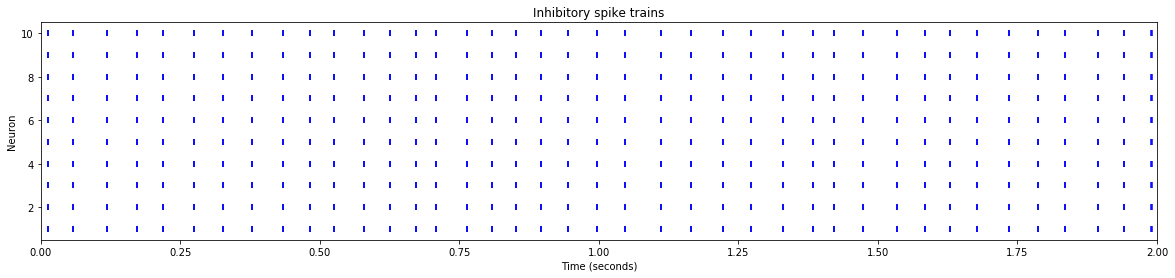

In [53]:
plot_trains(S[:100,:])
plt.xlim(0, 2.)
plt.ylim(0.5, 10.5)
plt.title("Inhibitory spike trains")

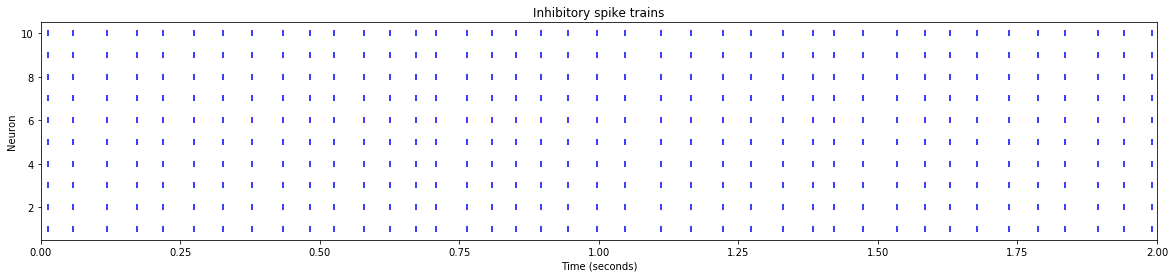

In [54]:
plot_trains(S[100:,:])
plt.xlim(0, 2.)
plt.ylim(0.5, 10.5)
plt.title("Inhibitory spike trains")

In [58]:
print("E mean = {}".format(np.mean(np.sum(S[:100,:]>0, 1),0)/2))
print("I mean = {}".format(np.mean(np.sum(S[100:,:]>0, 1),0)/2))

E mean = 40.0
I mean = 20.0


In [64]:
0+(S[0,100:200]>0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [65]:
0+(S[100,100:200]>0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])